In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Dense, Conv1D, MaxPooling1D
from keras.layers import Flatten, Concatenate, Dropout, Reshape, BatchNormalization
from keras.models import Model

# input file path
workdir = "E://Ronny_TF//200914_reupload//Dataset//Scenario2_EDC-11K"


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10586681505313592809
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10112512820
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13846861906815962867
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# input and index file
dataset = np.load(workdir + "//200914_EDC11K.npz")
ss0 = np.load(workdir + '//200914_EDC11K_r0_9_1.npz')

In [4]:
# input and index file assign
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [5]:
# training and test dataset assign
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]


In [7]:
# checking the size of dataset
x.shape

(11360, 21313)

In [8]:
# checking the size of training set
training_image_array.shape

(10224, 21313)

In [9]:
# hyperparameters of this model
num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100


In [10]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array




In [11]:
shape_value = 18988
print(shape_value)

18988


In [12]:
train_X.shape

(10224, 21313)

In [13]:
# data shaping for CNN model
train_X_cell = train_X[:,:shape_value]
train_X_drug =train_X[:,shape_value:]
test_X_cell = test_X[:,:shape_value]
test_X_drug = test_X[:,shape_value:]

In [14]:
train_X_cell.shape

(10224, 18988)

In [15]:
train_X_cell = train_X_cell.reshape(train_X_cell.shape[0], train_X_cell.shape[1], 1)
train_X_drug = train_X_drug.reshape(train_X_drug.shape[0], train_X_drug.shape[1], 1)
test_X_cell = test_X_cell.reshape(test_X_cell.shape[0], test_X_cell.shape[1], 1)
test_X_drug = test_X_drug.reshape(test_X_drug.shape[0], test_X_drug.shape[1], 1)
#input_shape = (img_rows, img_cols, 1)

In [16]:
# data shape
print(train_X_cell.shape,train_X_drug.shape, train_y.shape, test_X_cell.shape,test_X_drug.shape, test_y.shape)

(10224, 18988, 1) (10224, 2325, 1) (10224,) (1136, 18988, 1) (1136, 2325, 1) (1136,)


In [17]:
train_X_cell.shape

(10224, 18988, 1)

In [39]:
# data typing and the number of samples
train_X_cell = train_X_cell.astype('float32')
test_X_cell = test_X_cell.astype('float32')
train_X_drug = train_X_drug.astype('float32')
test_X_drug = test_X_drug.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (10224, 21313)
10224 train samples
1136 test samples


In [19]:
# model architecture
with K.tf.device('/GPU:0'):
    input_cell = Input(shape=(train_X_cell.shape[1], train_X_cell.shape[2]), name='cell_input')
    input_drug = Input(shape=(train_X_drug.shape[1], train_X_drug.shape[2]), name='drug_input')

    conv_cell_line_1 = Conv1D(filters=50, kernel_size=700, strides=5, activation='tanh')(input_cell)
    maxpool_cell_line_1 = MaxPooling1D(pool_size=5)(conv_cell_line_1)
    conv_cell_line_2 = Conv1D(filters=30, kernel_size=5, strides=2, activation='relu')(maxpool_cell_line_1)
    maxpool_cell_line_2 = MaxPooling1D(pool_size=10)(conv_cell_line_2)
    flatten_cell_line = Flatten()(maxpool_cell_line_2)
    dense_cell_line = Dense(100, activation='relu')(flatten_cell_line)
    dropout_cell_line = Dropout(0.1)(dense_cell_line)

    conv_drug_1 = Conv1D(filters=50, kernel_size=200, strides=3, activation='tanh')(input_drug)
    maxpool_drug_1 = MaxPooling1D(pool_size=5)(conv_drug_1)
    conv_drug_2 = Conv1D(filters=30, kernel_size=50, strides=5, activation='relu')(maxpool_drug_1)
    maxpool_drug_2 = MaxPooling1D(pool_size=10)(conv_drug_2)
    flatten_drug = Flatten()(maxpool_drug_2)
    dense_drug = Dense(100, activation='relu')(flatten_drug)
    dropout_drug = Dropout(0.1)(dense_drug)

    concatenate = Concatenate()([dropout_cell_line, dropout_drug])
    dense_1 = Dense(300, activation='tanh')(concatenate)
    dropout_1 = Dropout(0.1)(dense_1)
    reshape_1 = Reshape((300,1))(dropout_1)
    conv_1 = Conv1D(filters=30, kernel_size=150, strides=1, activation='relu')(reshape_1)
    maxpool_1 = MaxPooling1D(pool_size=2)(conv_1)
    conv_2 = Conv1D(filters=10, kernel_size=5, strides=1, activation='relu')(maxpool_1)
    maxpool_2 = MaxPooling1D(pool_size=3)(conv_2)
    conv_3 = Conv1D(filters=5, kernel_size=5, strides=1, activation='relu')(maxpool_2)
    maxpool_3 = MaxPooling1D(pool_size=3)(conv_3)
    dropout_2 = Dropout(0.1)(maxpool_3)
    flatten = Flatten()(dropout_2)
    dropout_3 = Dropout(0.2)(flatten)
    output = Dense(1, activation='linear', name='pred_lnIC50')(dropout_3)
    model = Model(inputs=[input_cell, input_drug], outputs=output, name='MasterModel')



W0915 09:55:50.641646 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:514: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 09:55:50.650437 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:71: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 09:55:50.652519 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:4076: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 09:55:50.675812 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:3900: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0915 09:55:50.708994 14964 dep

In [20]:
# model architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cell_input (InputLayer)         (None, 18988, 1)     0                                            
__________________________________________________________________________________________________
drug_input (InputLayer)         (None, 2325, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 3658, 50)     35050       cell_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 709, 50)      10050       drug_input[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [22]:
optim = Adam(lr=learning_rate)

model.compile(loss='mse',
		      optimizer=optim,
			  metrics=['mse','mae'])

StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit([train_X_cell, train_X_drug], train_y, validation_data=([test_X_cell, test_X_drug], test_y),
                            batch_size=batch_size,epochs=training_epochs,verbose=1)

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

W0915 09:56:11.208581 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



StartTime : 2020-09-15 09:56:11.223221


W0915 09:56:11.571108 14964 deprecation_wrapper.py:119] From c:\users\a\anaconda3\envs\tf_gpu_3.6\lib\site-packages\keras\backend\tensorflow_backend.py:983: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 10224 samples, validate on 1136 samples
Epoch 1/150
10224/10224 [==============================] - 7s 715us/step - loss: 4.0736 - mean_squared_error: 4.0736 - mean_absolute_error: 1.6161 - val_loss: 4.0510 - val_mean_squared_error: 4.0510 - val_mean_absolute_error: 1.4673
Epoch 2/150
10224/10224 [==============================] - 4s 356us/step - loss: 4.0243 - mean_squared_error: 4.0243 - mean_absolute_error: 1.5844 - val_loss: 4.0151 - val_mean_squared_error: 4.0151 - val_mean_absolute_error: 1.4793
Epoch 3/150
10224/10224 [==============================] - 4s 350us/step - loss: 4.0142 - mean_squared_error: 4.0142 - mean_absolute_error: 1.5791 - val_loss: 4.0230 - val_mean_squared_error: 4.0230 - val_mean_absolute_error: 1.4632
Epoch 4/150
10224/10224 [==============================] - 4s 350us/step - loss: 4.0066 - mean_squared_error: 4.0066 - mean_absolute_error: 1.5744 - val_loss: 3.9903 - val_mean_squared_error: 3.9903 - val_mean_absolute_error: 1.5063
Epoch 5/150
10224/1

Epoch 36/150
10224/10224 [==============================] - 4s 365us/step - loss: 3.8584 - mean_squared_error: 3.8584 - mean_absolute_error: 1.5154 - val_loss: 4.2197 - val_mean_squared_error: 4.2197 - val_mean_absolute_error: 1.7390
Epoch 37/150
10224/10224 [==============================] - 4s 364us/step - loss: 3.8635 - mean_squared_error: 3.8635 - mean_absolute_error: 1.5296 - val_loss: 4.0848 - val_mean_squared_error: 4.0848 - val_mean_absolute_error: 1.4944
Epoch 38/150
10224/10224 [==============================] - 4s 360us/step - loss: 3.8520 - mean_squared_error: 3.8520 - mean_absolute_error: 1.5234 - val_loss: 4.0530 - val_mean_squared_error: 4.0530 - val_mean_absolute_error: 1.5660
Epoch 39/150
10224/10224 [==============================] - 4s 359us/step - loss: 3.8436 - mean_squared_error: 3.8436 - mean_absolute_error: 1.5211 - val_loss: 4.0689 - val_mean_squared_error: 4.0689 - val_mean_absolute_error: 1.4664
Epoch 40/150
10224/10224 [==============================] - 4s 3

10224/10224 [==============================] - 4s 357us/step - loss: 3.8197 - mean_squared_error: 3.8197 - mean_absolute_error: 1.5056 - val_loss: 4.0846 - val_mean_squared_error: 4.0846 - val_mean_absolute_error: 1.5691
Epoch 72/150
10224/10224 [==============================] - 4s 360us/step - loss: 3.8238 - mean_squared_error: 3.8238 - mean_absolute_error: 1.5121 - val_loss: 4.0834 - val_mean_squared_error: 4.0834 - val_mean_absolute_error: 1.5494
Epoch 73/150
10224/10224 [==============================] - 4s 349us/step - loss: 3.8328 - mean_squared_error: 3.8328 - mean_absolute_error: 1.5099 - val_loss: 4.0717 - val_mean_squared_error: 4.0717 - val_mean_absolute_error: 1.5832
Epoch 74/150
10224/10224 [==============================] - 4s 348us/step - loss: 3.8251 - mean_squared_error: 3.8251 - mean_absolute_error: 1.5125 - val_loss: 4.1288 - val_mean_squared_error: 4.1288 - val_mean_absolute_error: 1.5487
Epoch 75/150
10224/10224 [==============================] - 4s 349us/step - l

10224/10224 [==============================] - 4s 351us/step - loss: 3.8189 - mean_squared_error: 3.8189 - mean_absolute_error: 1.5123 - val_loss: 4.1260 - val_mean_squared_error: 4.1260 - val_mean_absolute_error: 1.5956
Epoch 107/150
10224/10224 [==============================] - 4s 350us/step - loss: 3.8080 - mean_squared_error: 3.8080 - mean_absolute_error: 1.4979 - val_loss: 4.1309 - val_mean_squared_error: 4.1309 - val_mean_absolute_error: 1.5902
Epoch 108/150
10224/10224 [==============================] - 4s 351us/step - loss: 3.8096 - mean_squared_error: 3.8096 - mean_absolute_error: 1.5042 - val_loss: 4.1619 - val_mean_squared_error: 4.1619 - val_mean_absolute_error: 1.5242
Epoch 109/150
10224/10224 [==============================] - 4s 349us/step - loss: 3.8170 - mean_squared_error: 3.8170 - mean_absolute_error: 1.5038 - val_loss: 4.1561 - val_mean_squared_error: 4.1561 - val_mean_absolute_error: 1.5872
Epoch 110/150
10224/10224 [==============================] - 4s 348us/step

Epoch 141/150
10224/10224 [==============================] - 4s 349us/step - loss: 3.8155 - mean_squared_error: 3.8155 - mean_absolute_error: 1.5019 - val_loss: 4.0974 - val_mean_squared_error: 4.0974 - val_mean_absolute_error: 1.6242
Epoch 142/150
10224/10224 [==============================] - 4s 351us/step - loss: 3.8079 - mean_squared_error: 3.8079 - mean_absolute_error: 1.5053 - val_loss: 4.1204 - val_mean_squared_error: 4.1204 - val_mean_absolute_error: 1.5802
Epoch 143/150
10224/10224 [==============================] - 4s 349us/step - loss: 3.8083 - mean_squared_error: 3.8083 - mean_absolute_error: 1.5095 - val_loss: 4.2128 - val_mean_squared_error: 4.2128 - val_mean_absolute_error: 1.5069
Epoch 144/150
10224/10224 [==============================] - 4s 347us/step - loss: 3.8054 - mean_squared_error: 3.8054 - mean_absolute_error: 1.4975 - val_loss: 4.1896 - val_mean_squared_error: 4.1896 - val_mean_absolute_error: 1.6122
Epoch 145/150
10224/10224 [==============================] -

In [23]:
# model save
import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//200914_reupload//Result//EDC-11K"
# Option 1: Save Weights + Architecture
model.save_weights(workdir + '//EDC11K_CNN_model_fix_v3.h5')
with open(workdir + '//EDC11K_CNN_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())

In [24]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//EDC11K_CNN_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [25]:
# model evaluation
test_eval = model.evaluate([test_X_cell,test_X_drug], test_label_array, verbose=1)

1136/1136 [==============================] - 0s 270us/step


In [26]:
test_eval

[4.132146385354056, 4.132146385354056, 1.6384326370669082]

In [27]:
# loss record
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [28]:
# loss record
np.savetxt("EDC11K_CNN_acc_cls3_fix_2080ti_v3.csv", np_acc, delimiter=",")
np.savetxt("EDC11K_CNN_val_acc_cls3_fix_2080ti_v3.csv", np_val_acc, delimiter=",")
np.savetxt("EDC11K_CNN_loss_cls3_fix_2080ti_v3.csv", np_loss, delimiter=",")
np.savetxt("EDC11K_CNN_val_loss_cls3_fix_2080ti_v3.csv", np_val_loss, delimiter=",")

In [29]:
import matplotlib
from matplotlib import pyplot as plt

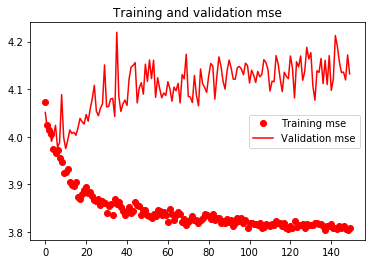

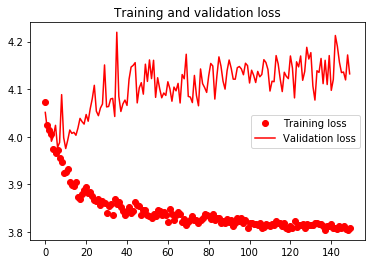

In [30]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse',c='red')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse',c='red')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss',c='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',c='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [31]:
predicted_classes = model.predict([test_X_cell,test_X_drug])

In [32]:
predicted_value = predicted_classes

In [33]:
# saving predicted ln(IC50)s and ln(IC50)s in the test set
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]
c.to_csv(workdir + '//200915_EDC11K_CNN_pred_and_val_result.csv', index=False)


In [41]:
# result table
c.head()

,Predicted,Test
0,0.369521,2.079442
1,0.509466,-3.022156
2,0.097100,2.079442
3,1.312388,2.079442
4,0.790176,2.079442


In [36]:
predicted_value.shape

(1136, 1)

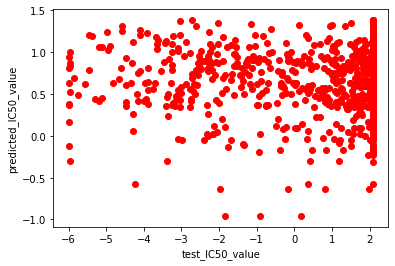

In [37]:
# scatter plot
plt.scatter(test_label_array,predicted_value,c='red')
plt.xlabel('test_IC50_value')
plt.ylabel('predicted_IC50_value')
plt.savefig(workdir + '//EDC11K_CNN_test_scatterplot.png')

In [42]:
# R-squared value
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

-0.027870371071846867


In [43]:
# Linear regression value (slope)
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.007505670930101758, intercept=0.6759877147652715, rvalue=0.041148354789516214, pvalue=0.16576248823961323, stderr=0.005412059146859292)

In [44]:
# RMSE
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 2.0327681302061427
